# Spectrum

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("../src/")

import partition_energy

In [2]:
hamils = partition_energy.read_splits("hamiltonians", (1000, 28, 28), "1000ps_100fs", screened=False)
distan = partition_energy.read_splits("distances", (1000, 27, 27), "1000ps_100fs", screened=False)
dipols = partition_energy.read_splits("transition_dipoles", (1000, 27, 3), "1000ps_100fs", screened=False)
eigvec = partition_energy.read_splits("eigenvectors", (1000, 28, 28), "1000ps_100fs", screened=False)
eigvec = eigvec.transpose(0, 2, 1)

states = partition_energy.read_splits("states_energies", (1000, 28), "1000ps_100fs", screened=False)

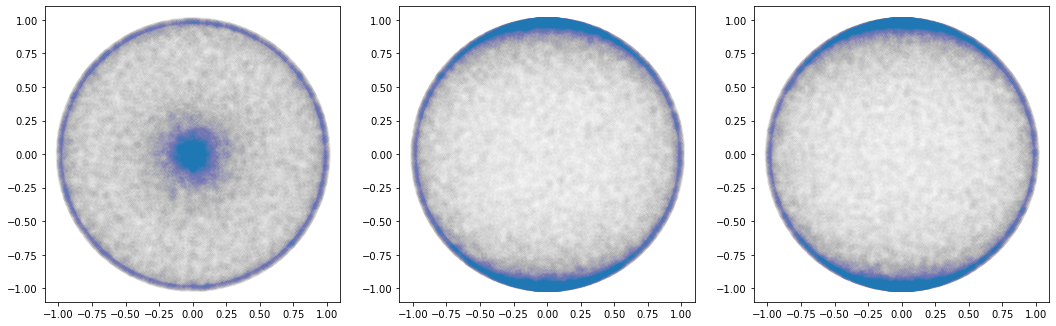

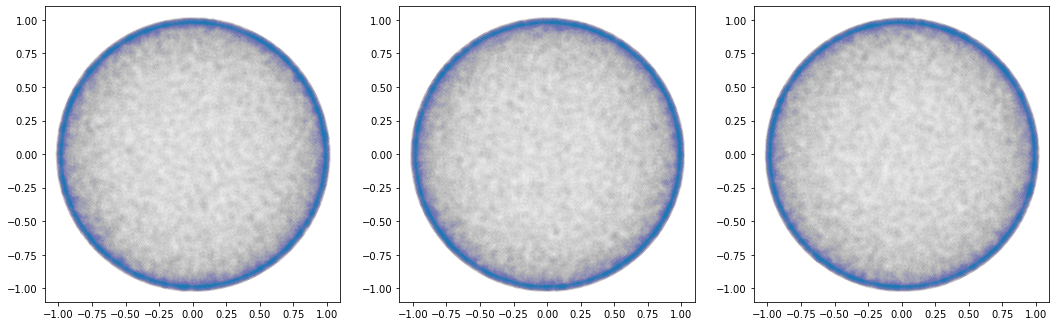

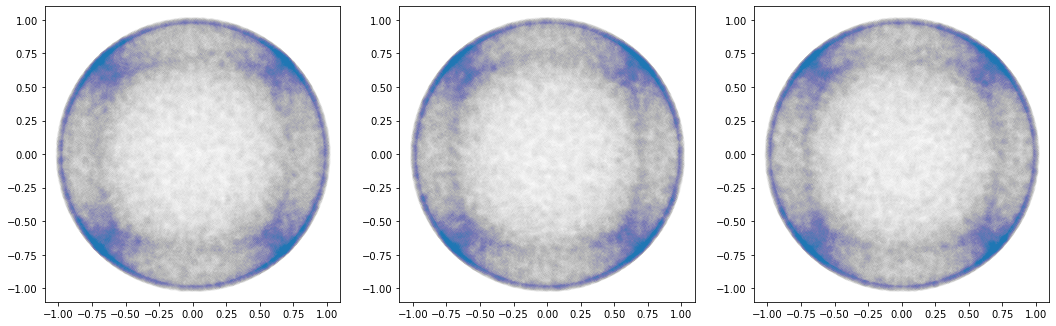

In [43]:
def random_unit_vectors_polar(n):
    phi = np.random.uniform(0, 2*np.pi, n)
    psi = np.random.uniform(0, np.pi, n)
    
    x = np.cos(phi) * np.sin(psi)
    y = np.sin(phi) * np.sin(psi)
    z = np.cos(psi)
    
    return np.vstack((x, y, z)).T

def random_unit_vectors(n):
    rand = np.random.normal(0, 0.01, size=(n, 3))
    
    norms = np.linalg.norm(rand, axis=1)
    norm_stk = np.vstack((norms, norms, norms)).T
    
    return rand/norm_stk

def random_unit_vectors_uniform(n):
    rand = np.random.uniform(-1, 1, size=(n, 3))
    
    norms = np.linalg.norm(rand, axis=1)
    norm_stk = np.vstack((norms, norms, norms)).T
    
    return rand/norm_stk

temp = random_unit_vectors_polar(100000)

fig, ax = plt.subplots(1, 3)
ax[0].scatter(temp[:, 0], temp[:, 1], alpha=0.005)
ax[1].scatter(temp[:, 0], temp[:, 2], alpha=0.005)
ax[2].scatter(temp[:, 1], temp[:, 2], alpha=0.005)

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[2].set_aspect('equal')

fig.set_size_inches(18, 6)

temp = random_unit_vectors(100000)

fig, ax = plt.subplots(1, 3)
ax[0].scatter(temp[:, 0], temp[:, 1], alpha=0.005)
ax[1].scatter(temp[:, 0], temp[:, 2], alpha=0.005)
ax[2].scatter(temp[:, 1], temp[:, 2], alpha=0.005)

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[2].set_aspect('equal')

fig.set_size_inches(18, 6)

temp = random_unit_vectors_uniform(100000)

fig, ax = plt.subplots(1, 3)
ax[0].scatter(temp[:, 0], temp[:, 1], alpha=0.005)
ax[1].scatter(temp[:, 0], temp[:, 2], alpha=0.005)
ax[2].scatter(temp[:, 1], temp[:, 2], alpha=0.005)

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[2].set_aspect('equal')

fig.set_size_inches(18, 6)

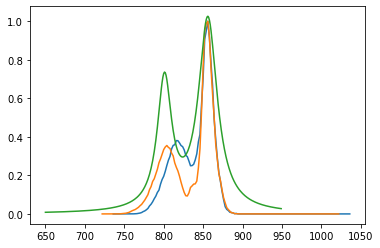

In [45]:
def absorption(dipoles, eigvec):
    intensities = np.empty((len(dipoles), 27))
    
    for f in range(len(dipoles)):
        dip_f = dipoles[f]
        eig_f = eigvec[f]
        
        e = random_unit_vectors(1)[0]        
        overlap = dip_f @ e
        
        overlap = np.repeat(overlap, 27).reshape(27, 27)
        
        contrib = eig_f[1:, 1:] * overlap

        intensities[f] = np.square(np.sum(contrib, axis=0))
        
    return intensities


def hartree_to_nm(x):
    c = 299792458 #speed of light, m/s
    h = 6.626e-34 #Planck constant
    J_per_Eh = 4.35974e-18 # J/Eh
    
    wavelength = (h*c) / (x * J_per_Eh)
    
    return 1e9 * wavelength # m to nm conversion


def hartree_to_pcm(x):
    c = 299792458 #speed of light, m/s
    h = 6.626e-34 #Planck constant
    J_per_Eh = 4.35974e-18 # J/Eh
    
    wavenumber = (x * J_per_Eh) / (h*c)
    
    return 1e-2 * wavenumber # m-1 to cm-1 conversion


def make_screening(distances, a=2.68, b=0.14, f0=0.54):
    screen = np.ones((distances.shape[0], 28, 28))
    
    for i in range(len(distances)):
        screen[i, 1:, 1:] = a * np.exp(-b * distances[i]) + f0
    
        np.fill_diagonal(screen[i], 1)
    
    return screen


def line_shape(intensities, energies):
    assert(intensities.shape == energies.shape)
    
    intensities = intensities.flatten()
    energies = energies.flatten()
    
    args = np.argsort(energies)
    
    energies, intensities = energies[args], intensities[args]
    
    bins = np.linspace(600, 900, 151)

    digits = np.digitize(energies, bins)
    
    summed_intensities = np.zeros(len(bins))
    
    for i in range(len(bins)):
        indices = np.where(digits == i)[0]
        
        if len(indices) == 0:
            continue
        
        summed_intensities[i] = np.sum(intensities[indices])
    
    return bins, summed_intensities/np.max(summed_intensities)


def screen_hamiltonians(distances, hamiltonians, a, b, f0):
    states, eigvec = np.linalg.eigh(make_screening(distan, a, b, f0) * hamils)

    return states, eigvec

    
def trial_screening(distances, hamiltonians, dipoles,  a, b, f0, ax, peak_max):
    states, eigvec = screen_hamiltonians(distances, hamiltonians, a, b, f0)
    
    exciton_excitations = np.array([states[:, i] - states[:, 0] for i in range(1, 28)]).T
    exciton_excitations_nm = hartree_to_nm(exciton_excitations)

    intensities = absorption(dipoles, eigvec)

    bins, summed_ints = line_shape(intensities, exciton_excitations_nm)

    shift = peak_max - bins[np.argmax(summed_ints)]
    
    ax.plot(bins+shift, summed_ints);
    

def reference(states, dipoles, eigvecs, ax, peak_max):
    exciton_excitations = np.array([states[:, i] - states[:, 0] for i in range(1, 28)]).T
    exciton_excitations_nm = hartree_to_nm(exciton_excitations)

    intensities = absorption(dipoles, eigvecs)

    bins, summed_ints = line_shape(intensities, exciton_excitations_nm)

    shift = peak_max - bins[np.argmax(summed_ints)]
    
    ax.plot(bins+shift, summed_ints);

    
def gaussian_value_generator(peak, FWHM, x):
    gamma = FWHM/2 #see https://en.wikipedia.org/wiki/Full_width_at_half_maximum
    return 1/((np.pi * gamma) * (1 + ((x - peak)/gamma)**2))


def plot_experimental(ax):
    """
    data got from "G. Absorption and CD Spectroscopy and Modelling of Various LH2 Complexes from Purple Bacteria. Biophys. J. 2002, 82, 2184−2197"
    using Rps. acidophila (10050), RT row of data from Table 1 for values
    (LH2 complex was taken from this species of bacteria)
    peaks 801 nm, 856 nm, full width at half maximum 22 and 29 respectively.
    B850 peak maximum is 1.49 times greater than B800
    """

    B850_peak = 856
    B800_peak = 801

    B850_FWHM = 29
    B800_FWHM = 22
    
    nanometer_range = np.arange(650, 950)

    B850_line = gaussian_value_generator(B850_peak, B850_FWHM, nanometer_range)
    B850_line /= max(B850_line)

    B800_line = gaussian_value_generator(B800_peak, B800_FWHM, nanometer_range)
    B800_line /= (max(B800_line) * 1.49)

    spectrum = [sum(x) for x in zip(B800_line, B850_line)]
    
    ax.plot(nanometer_range, spectrum)

fig, ax = plt.subplots()

reference(states, dipols, eigvec, ax, 856)
trial_screening(distan, hamils, dipols, 0., 0., 1.4, ax, 856)
plot_experimental(ax)


In [65]:
def plot_density(vecs, ax):
    density = np.square(vecs)
    sum_dens = np.sum(density, axis=0)

    print(sum_dens.shape)

    b800 = list(range(1, 27, 3))
    b850a = list(range(2, 27, 3))
    b850b = list(range(3, 27, 3))

    ax.imshow(sum_dens[1:, 1:][b800+b850a+b850b], cmap='YlGn')
    
    return sum_dens[1:, 1:][b800+b850a+b850b]

(28, 28)
(28, 28)


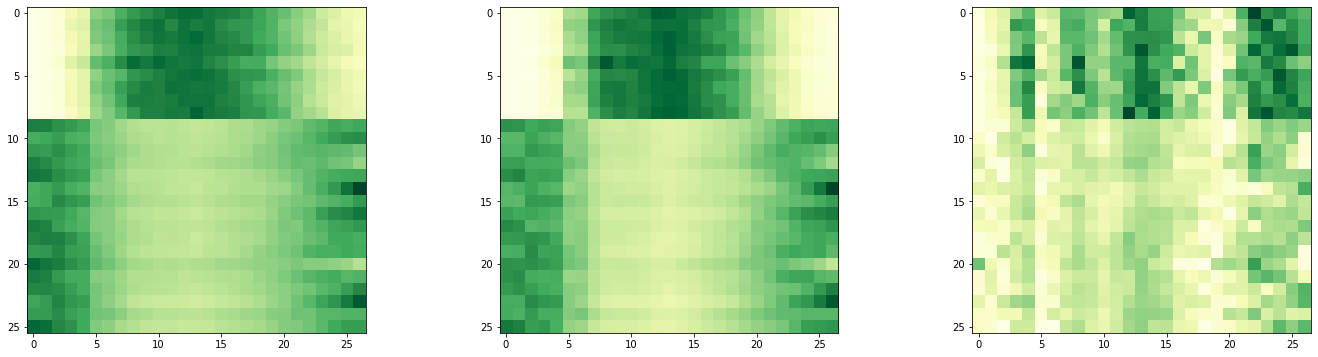

In [69]:
screened_states, screened_eigvecs = screen_hamiltonians(distan, hamils, 0., 0., 1.4)

fig, ax = plt.subplots(1, 3)

a = plot_density(eigvec, ax[0])
b = plot_density(screened_eigvecs, ax[1])
ax[2].imshow(abs(a-b), cmap='YlGn')

fig.set_size_inches(24,6)